# Abstract
Business problem
- banks faceses heigh loss due to defaulters , we have to predict person will be defaulter or not with probablity of him to be defaulter

ML foormulaion
- this is binary classification task 
- in this task we have predict probablity of person to be defaulter or not
- in this problem it is important to have less false posiitve rate becase it can costs heigh loss to the bank 
- matix for evaluation is auc matrix
- interpritability is important to give beacuse of which features preson should be defaulter one 

first cut approach
- first we will perform basic EDA 
- Handling of missing data
- Handle imbalence dataset
- after data perparation we will add some new features 
- Do required preprocessing over data (numerical ,categorical and text features)
- apply ml model
- predict submission

In [ ]:
%matplotlib inline
%pip install chart-studio
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.impute import SimpleImputer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

     |████████████████████████████████| 64 kB 1.9 MB/s 


In [ ]:
train_data = pd.read_csv('train_indessa.csv')
test_data = pd.read_csv('test_indessa.csv')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532428 entries, 0 to 532427
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    532428 non-null  int64  
 1   loan_amnt                    532428 non-null  int64  
 2   funded_amnt                  532428 non-null  int64  
 3   funded_amnt_inv              532428 non-null  float64
 4   term                         532428 non-null  object 
 5   batch_enrolled               447279 non-null  object 
 6   int_rate                     532428 non-null  float64
 7   grade                        532428 non-null  object 
 8   sub_grade                    532428 non-null  object 
 9   emp_title                    501595 non-null  object 
 10  emp_length                   505537 non-null  object 
 11  home_ownership               532428 non-null  object 
 12  annual_inc                   532425 non-null  float64
 13 

In [ ]:

dtypes = train_data.dtypes
categorical = dtypes[dtypes=='object']
print('following are categorical features')
catgs = np.array(categorical.keys())
cat_feature = catgs[catgs != 'desc']
print(cat_feature)

following are categorical features
['term' 'batch_enrolled' 'grade' 'sub_grade' 'emp_title' 'emp_length'
 'home_ownership' 'verification_status' 'pymnt_plan' 'purpose' 'title'
 'zip_code' 'addr_state' 'initial_list_status' 'application_type'
 'verification_status_joint' 'last_week_pay']


In [ ]:
print('desc is text feature')

desc is text feature


In [ ]:
dtypes = train_data.dtypes
categorical = dtypes[dtypes!='object']
print('following are numeric features')
int_features = np.array(categorical.keys())

print(int_features , int_features.shape[0])

following are numeric features
['member_id' 'loan_amnt' 'funded_amnt' 'funded_amnt_inv' 'int_rate'
 'annual_inc' 'dti' 'delinq_2yrs' 'inq_last_6mths'
 'mths_since_last_delinq' 'mths_since_last_record' 'open_acc' 'pub_rec'
 'revol_bal' 'revol_util' 'total_acc' 'total_rec_int' 'total_rec_late_fee'
 'recoveries' 'collection_recovery_fee' 'collections_12_mths_ex_med'
 'mths_since_last_major_derog' 'acc_now_delinq' 'tot_coll_amt'
 'tot_cur_bal' 'total_rev_hi_lim' 'loan_status'] 27


In [ ]:
print("Number of data points in train data", train_data.shape)
print('-'*50)
print("The attributes of data :", train_data.columns.values)

Number of data points in train data (532428, 45)
--------------------------------------------------
The attributes of data : ['member_id' 'loan_amnt' 'funded_amnt' 'funded_amnt_inv' 'term'
 'batch_enrolled' 'int_rate' 'grade' 'sub_grade' 'emp_title' 'emp_length'
 'home_ownership' 'annual_inc' 'verification_status' 'pymnt_plan' 'desc'
 'purpose' 'title' 'zip_code' 'addr_state' 'dti' 'delinq_2yrs'
 'inq_last_6mths' 'mths_since_last_delinq' 'mths_since_last_record'
 'open_acc' 'pub_rec' 'revol_bal' 'revol_util' 'total_acc'
 'initial_list_status' 'total_rec_int' 'total_rec_late_fee' 'recoveries'
 'collection_recovery_fee' 'collections_12_mths_ex_med'
 'mths_since_last_major_derog' 'application_type'
 'verification_status_joint' 'last_week_pay' 'acc_now_delinq'
 'tot_coll_amt' 'tot_cur_bal' 'total_rev_hi_lim' 'loan_status']


Number of members thar are Defaulters  125827 , ( 23.632678972555915 %)
Number of projects thar are non defaulters  406601 , ( 76.36732102744409 %)


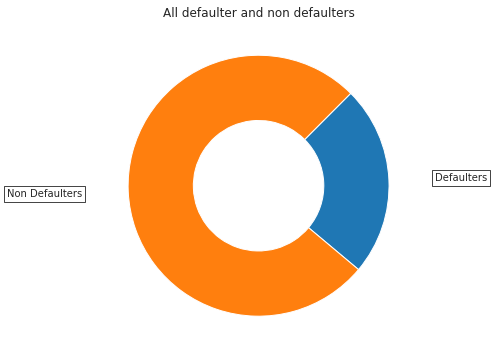

In [ ]:
y_value_counts = train_data['loan_status'].value_counts()
print("Number of members thar are Defaulters ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are non defaulters ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Defaulters", "Non Defaulters"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("All defaulter and non defaulters")

plt.show()

### we can say that data is imbalence data 


1.   we will chosse to understamplig to deal with an imbalence dataset 
2.   we will choose over sampling to deal with imbalence data because with undersampling we dont want to loose the information
3.   we will goin to do oversampling of minority class upto 2:3 ration



In [ ]:
blank_spaces = train_data.eq(' ').sum()
blank_spaces

member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
batch_enrolled                 106079
int_rate                            0
grade                               0
sub_grade                           0
emp_title                           0
emp_length                          0
home_ownership                      0
annual_inc                          0
verification_status                 0
pymnt_plan                          0
desc                                0
purpose                             0
title                               0
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                         0
inq_last_6mths                      0
mths_since_last_delinq              0
mths_since_last_record              0
open_acc                            0
pub_rec     

In [ ]:
# we will check nan values in overall dataset
# review the columns with heighest amount of nan values
na_values = train_data.isna().sum()
na_values

member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
batch_enrolled                  85149
int_rate                            0
grade                               0
sub_grade                           0
emp_title                       30833
emp_length                      26891
home_ownership                      0
annual_inc                          3
verification_status                 0
pymnt_plan                          0
desc                           456829
purpose                             0
title                              90
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        16
inq_last_6mths                     16
mths_since_last_delinq         272554
mths_since_last_record         450305
open_acc                           16
pub_rec     

In [ ]:
#columns with nan value
train_data.isna().any(axis=0).sum().sum()

21

- so we can find there are huge no of nan values in some columns so we will going to exclude those columns whose contains more that 50 % of nan values 
- for features whose are beetwen 0 to 50 % of nan values we will going replace them with median if they are numerical features and if they are categorical then we will going to replace them by most occuring category

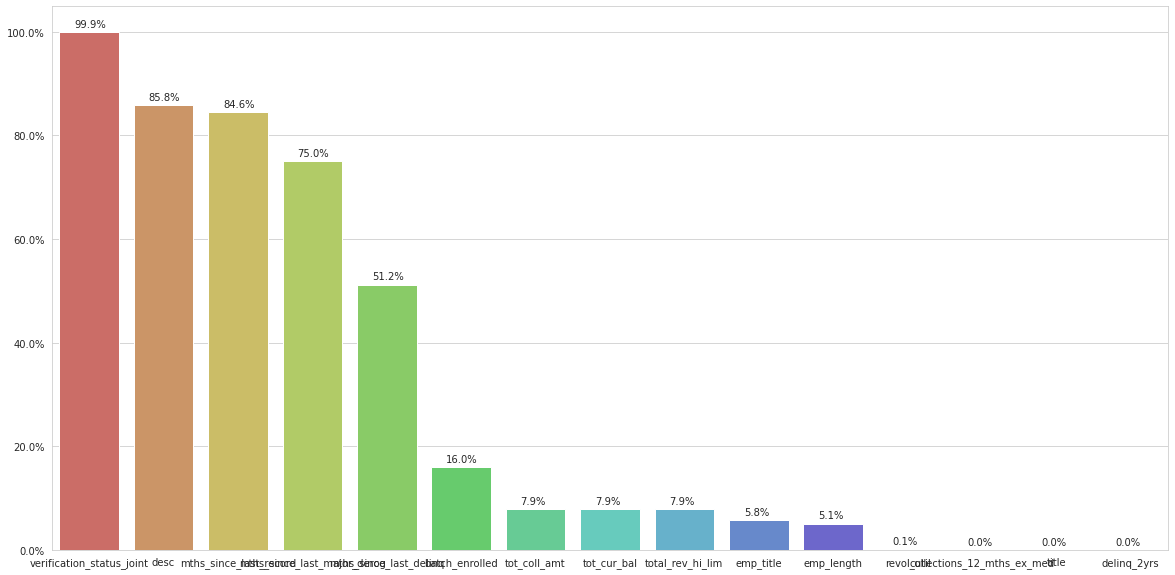

In [ ]:
# Creating a dictionary whose keys are the column names and values are the percentage of missing values
x = train_data
nan_count = {k:list(x.isna().sum()*100/x.shape[0])[i] for i,k in enumerate(x.columns)}

# Sorting the dictionary in descending order based on the percentage of missing values
nan_count = {k: v for k, v in sorted(nan_count.items(), key=lambda item: item[1],reverse=True)}

# Plotting a graph showing the top 15 features having highest percentage of missing values 
sns.set_style(style="whitegrid")
plt.figure(figsize=(20,10))

# Bar Plot
plot = sns.barplot(x= list(nan_count.keys())[:15],y = list(nan_count.values())[:15],palette="hls")

# Add annotations above each bar signifying their value
for p in plot.patches:
        plot.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+1))

# Make y-axis more interpretable
plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs())) 
plt.show()

In [ ]:
print('columns whose having nan values more than 50% ')
x = nan_count
sorted_x = sorted(x.items(), key=lambda kv: kv[1], reverse=True)
heigh_na_features = {i:j for i,j in sorted_x if j > 50}
print(heigh_na_features)
print('columns whose having nan values less than 50%')
medium_na_features = {i:j for i,j in sorted_x if j <= 50 and j > 0} 
print(medium_na_features)

columns whose having nan values more than 50% 
{'verification_status_joint': 99.94271525915241, 'desc': 85.80108484151847, 'mths_since_last_record': 84.57575484384743, 'mths_since_last_major_derog': 75.02385299045129, 'mths_since_last_delinq': 51.19077133434004}
columns whose having nan values less than 50%
{'batch_enrolled': 15.99258491288963, 'tot_coll_amt': 7.889141818236457, 'tot_cur_bal': 7.889141818236457, 'total_rev_hi_lim': 7.889141818236457, 'emp_title': 5.791017752635098, 'emp_length': 5.05063595453282, 'revol_util': 0.05390400204346879, 'collections_12_mths_ex_med': 0.017842788132855524, 'title': 0.01690369402059997, 'delinq_2yrs': 0.0030051011592177723, 'inq_last_6mths': 0.0030051011592177723, 'open_acc': 0.0030051011592177723, 'pub_rec': 0.0030051011592177723, 'total_acc': 0.0030051011592177723, 'acc_now_delinq': 0.0030051011592177723, 'annual_inc': 0.0005634564673533323}


In [ ]:
train_data_preprocessed = train_data
test_data_preprocessed = test_data

In [ ]:
#drop the columns having missing values rate > 50%
train_data_preprocessed = train_data_preprocessed.drop(columns=['verification_status_joint', 'desc', 'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq'])

In [ ]:
train_data_preprocessed.shape

(532428, 40)

# Handle missing values

- batch batch_enrolled feature contains nan values + blank spaces 
- this is total nearly 35.9 % of total rows 
- as we are not domain expert we cant tell values whcih are missing are missing reandomly or the missing value have its own meaning 
- there are three options in this case
   - remove column 
   - replace spaces and nan with most frequest value 
   - conside  blank space and nan as new categories
- we will choose third option 

In [ ]:
(blank_spaces['batch_enrolled']+na_values['batch_enrolled'])/train_data.shape[0]

0.3591621777968101

In [ ]:
train_data_preprocessed['batch_enrolled'] = train_data_preprocessed['batch_enrolled'].fillna('unknown')

In [ ]:
train_data_preprocessed['batch_enrolled'] = train_data_preprocessed['batch_enrolled'].map(lambda x: 'blank' if x == ' ' else x)

In [ ]:
batch_enrolled = train_data_preprocessed['batch_enrolled']
print(batch_enrolled[batch_enrolled=='blank'].shape , batch_enrolled[batch_enrolled=='unknown'].shape) 

(106079,) (85149,)


In [ ]:
 train_data_preprocessed['batch_enrolled']

0              blank
1         BAT1586599
2         BAT1586599
3         BAT4808022
4         BAT2833642
             ...    
532423         blank
532424    BAT2003848
532425       unknown
532426    BAT3193689
532427    BAT4136152
Name: batch_enrolled, Length: 532428, dtype: object

In [ ]:
medium_na_features
categorical_na_features = list(filter(lambda x: x in cat_feature,list(medium_na_features.keys())))
int_na_features = list(filter(lambda x: x in int_features,list(medium_na_features.keys())))


In [ ]:
categorical_na_features

['batch_enrolled', 'emp_title', 'emp_length', 'title']

In [ ]:
int_na_features

['tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'revol_util',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'total_acc',
 'acc_now_delinq',
 'annual_inc']

In [ ]:
def replace_with_most_frequent (feature):
   values_data = train_data_preprocessed[feature].value_counts()
   max_value = values_data[values_data == values_data.max()].index[0]
   return train_data_preprocessed[feature].fillna(max_value[0]) , max_value

In [ ]:
def fill_cat_na(categorical_na_features):
  save_feature_max_value = dict({})
  for i in categorical_na_features:
    feature , val =  replace_with_most_frequent(i)
    train_data_preprocessed[i] = feature
    save_feature_max_value[i] = val
  pickle.dump(save_feature_max_value, file = open("save_feature_max_value.pickle", "wb"))
  save_feature_max_value = pickle.load(open("save_feature_max_value.pickle", "rb"))
  return save_feature_max_value

In [ ]:
fill_cat_na(categorical_na_features)

{'batch_enrolled': 'blank',
 'emp_length': '10+ years',
 'emp_title': 'Teacher',
 'title': 'Debt consolidation'}

In [ ]:
save_feature_max_value = pickle.load(open("save_feature_max_value.pickle", "rb"))
save_feature_max_value

{'batch_enrolled': 'blank',
 'emp_length': '10+ years',
 'emp_title': 'Teacher',
 'title': 'Debt consolidation'}

In [ ]:
def replace_with_median (feature):
    median_value =  train_data_preprocessed[feature].median()
    train_feature = train_data_preprocessed[feature].fillna(median_value)
    return train_feature , median_value

In [ ]:
def fill_int_na(int_na_features):
  save_feature_median_value = dict({})
  for i in int_na_features:
    feature , val =  replace_with_median(i)
    train_data_preprocessed[i] = feature
    save_feature_median_value[i] = val
  pickle.dump(save_feature_median_value, file = open("save_feature_median_value.pickle", "wb"))
  save_feature_median_value = pickle.load(open("save_feature_median_value.pickle", "rb"))
  return save_feature_median_value

In [ ]:
fill_int_na(int_na_features)

{'acc_now_delinq': 0.0,
 'annual_inc': 65000.0,
 'collections_12_mths_ex_med': 0.0,
 'delinq_2yrs': 0.0,
 'inq_last_6mths': 0.0,
 'open_acc': 11.0,
 'pub_rec': 0.0,
 'revol_util': 56.0,
 'tot_coll_amt': 0.0,
 'tot_cur_bal': 80669.5,
 'total_acc': 24.0,
 'total_rev_hi_lim': 23700.0}

In [ ]:
train_data_preprocessed.isna().sum()

member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
batch_enrolled                0
int_rate                      0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
pymnt_plan                    0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collecti

#Basic EDA

In [ ]:
dtypes = train_data_preprocessed.dtypes
categorical = dtypes[dtypes=='object']
print('following are categorical features')
catgs = np.array(categorical.keys())
preprocess_cat_feature = catgs[catgs != 'desc']
print(preprocess_cat_feature ,preprocess_cat_feature.shape)

following are categorical features
['term' 'batch_enrolled' 'grade' 'sub_grade' 'emp_title' 'emp_length'
 'home_ownership' 'verification_status' 'pymnt_plan' 'purpose' 'title'
 'zip_code' 'addr_state' 'initial_list_status' 'application_type'
 'last_week_pay'] (16,)


In [ ]:
dtypes = train_data_preprocessed.dtypes
categorical = dtypes[dtypes!='object']
print('following are numerical features')
catgs = np.array(categorical.keys())
preprocess_int_feature = catgs[np.logical_and(catgs != 'member_id', catgs != 'loan_status') ]
print(preprocess_int_feature.shape)
preprocess_int_feature

following are numerical features
(22,)


array(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'], dtype=object)

In [ ]:
def printCounterPlot(feature , row): 
  # count plot on two categorical variable
  if train_data_preprocessed[feature].value_counts().shape[0] > 30:
    return
  sns.countplot(x = feature, hue = "loan_status", data = train_data_preprocessed)
  plt.show()

In [ ]:
train_data_preprocessed.loan_status.value_counts()

0    406601
1    125827
Name: loan_status, dtype: int64

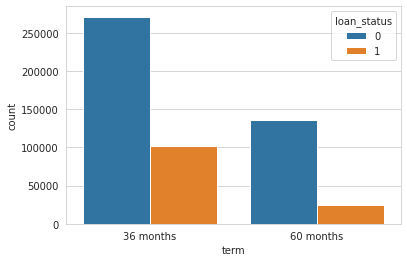

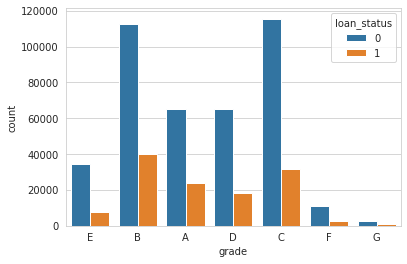

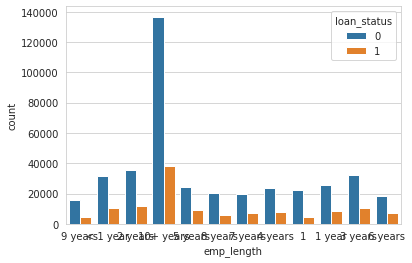

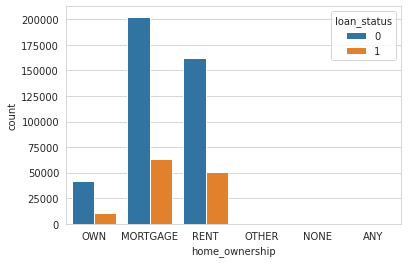

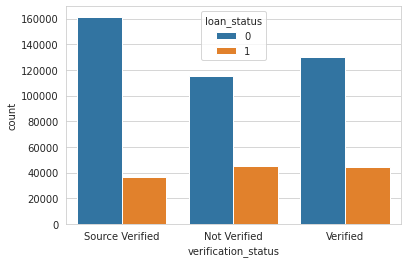

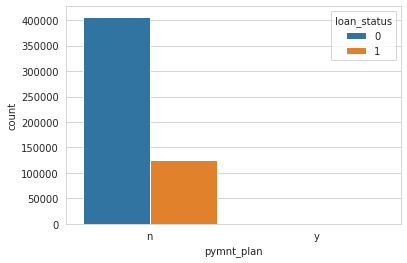

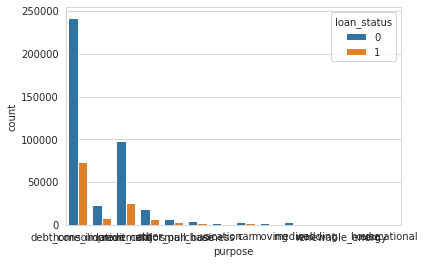

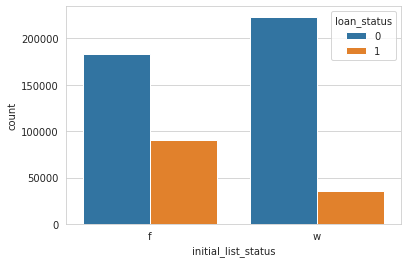

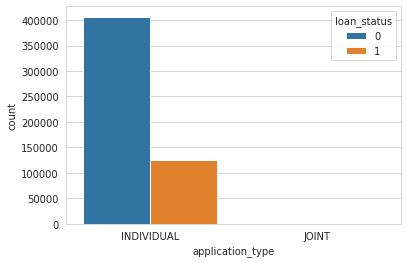

In [ ]:
### Data Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt


for idx,cat_col in enumerate(preprocess_cat_feature):
    printCounterPlot(cat_col,idx)
#plt.subplots_adjust(hspace=1)

In [ ]:
train_data_preprocessed.application_type.value_counts()

INDIVIDUAL    532123
JOINT            305
Name: application_type, dtype: int64

In [ ]:
application_type = train_data_preprocessed[train_data_preprocessed.loan_status == 0].application_type
application_type[application_type == 'JOINT'].shape[0]

304

In [ ]:
application_type = train_data_preprocessed[train_data_preprocessed.loan_status == 1].application_type
application_type[application_type == 'JOINT'].shape[0]

1

In [ ]:
train_data_preprocessed.pymnt_plan.value_counts()

n    532420
y         8
Name: pymnt_plan, dtype: int64

In [ ]:
pymnt_plan = train_data_preprocessed[train_data_preprocessed.loan_status == 0].pymnt_plan
application_type[application_type == 'y'].shape[0]

0

In [ ]:
 train_data_preprocessed = train_data_preprocessed.drop(columns=['application_type', 'pymnt_plan'])

- in our dataset if we see mostly all members having individual application type we so if we drop this feature it will not affect result much 
- same is about pymnt_plan feature almost all the members having pymnt_plan category n so this feature can misguide us
- we will drop this two features from categorical features 

In [ ]:
def plotPdf(feature):  
  defaulter = train_data_preprocessed[train_data_preprocessed['loan_status']==1][feature].values
  non_defaulter = train_data_preprocessed[train_data_preprocessed['loan_status']==0][feature].values
  plt.figure(figsize=(10,3))
  sns.distplot(defaulter, hist=False, label="Defaulters")
  sns.distplot(non_defaulter, hist=False, label="Non Defaulters")
  plt.title(feature+' pdf')
  plt.xlabel(feature+' range')
  plt.legend()
  plt.show()

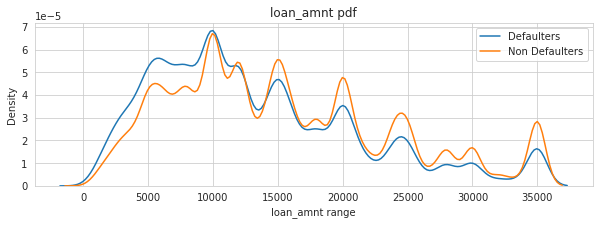

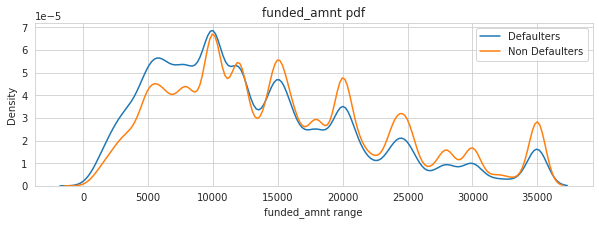

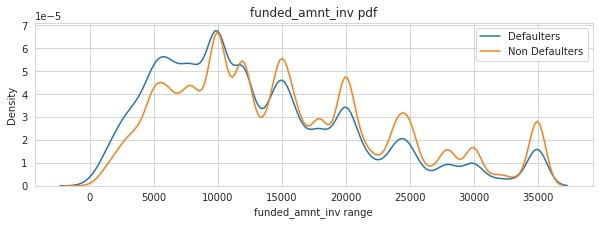

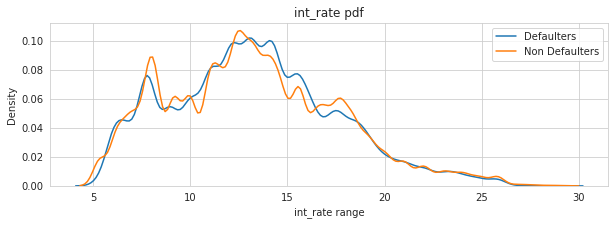

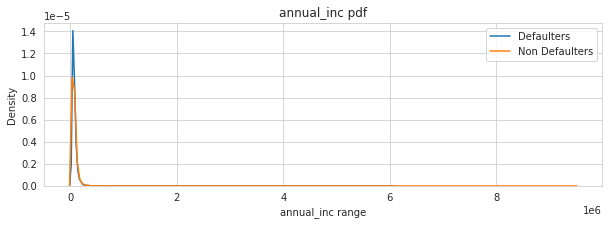

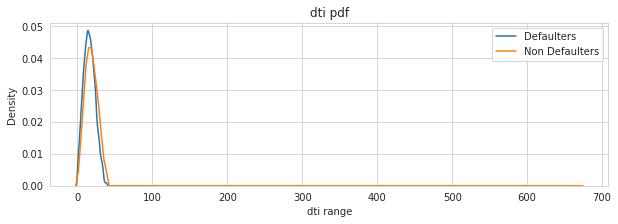

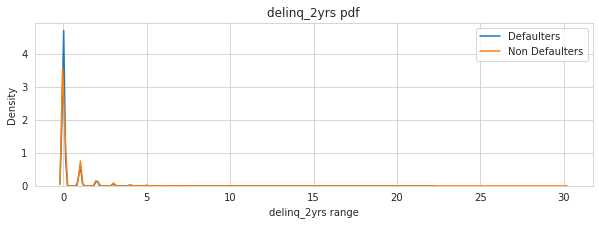

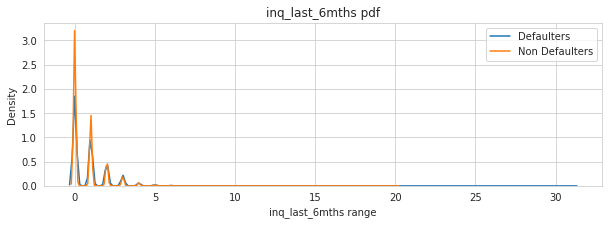

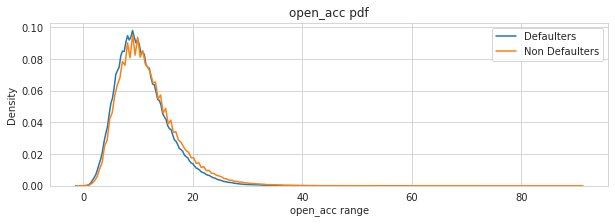

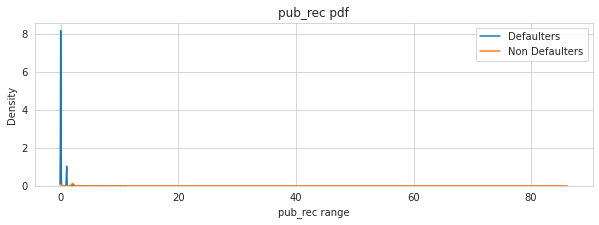

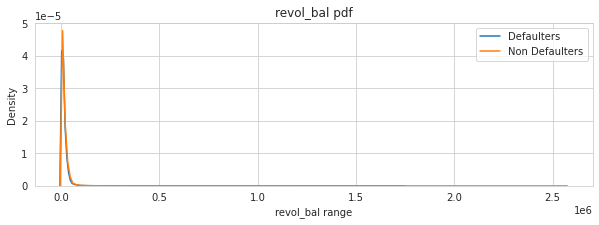

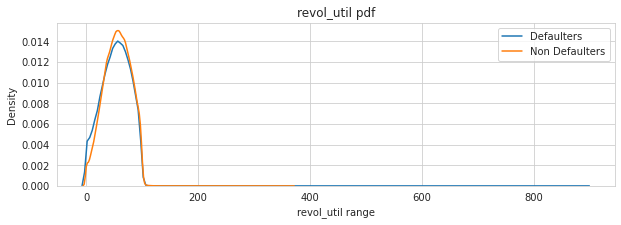

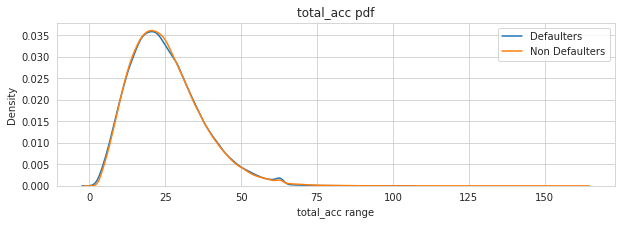

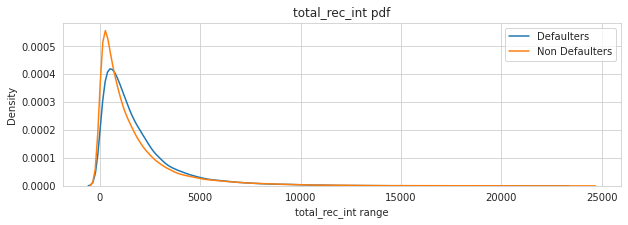

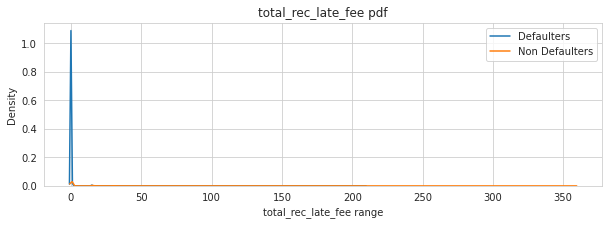

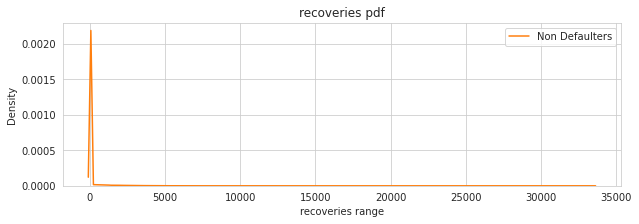

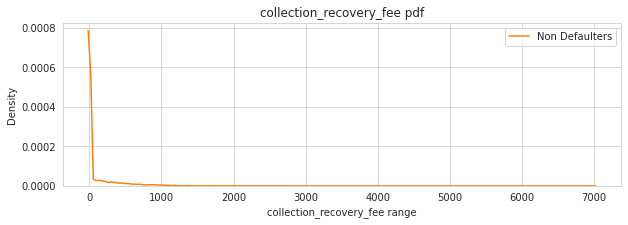

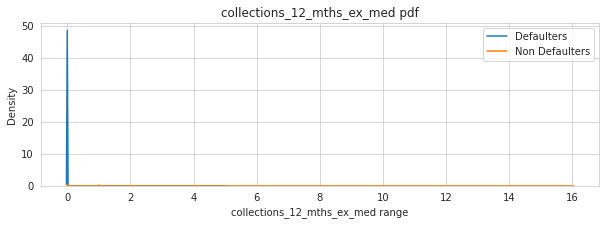

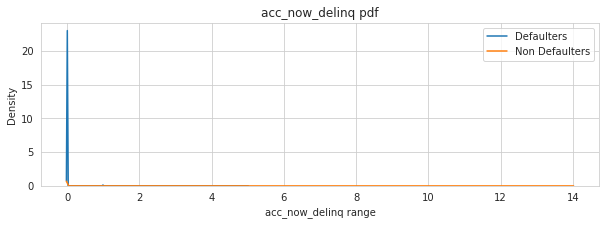

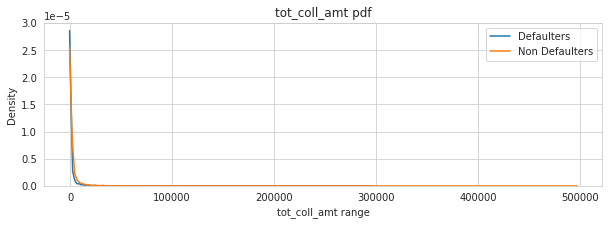

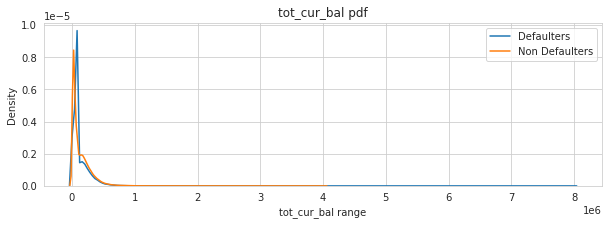

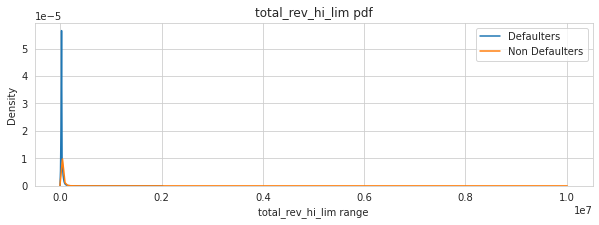

In [ ]:
for idx,cat_col in enumerate(preprocess_int_feature):
    plotPdf(cat_col)

In [ ]:

train_data_preprocessed[train_data_preprocessed.loan_status == 1].collection_recovery_fee.value_counts()

0.0    125827
Name: collection_recovery_fee, dtype: int64

In [ ]:
train_data_preprocessed[train_data_preprocessed.loan_status == 1].recoveries.value_counts()

0.0    125827
Name: recoveries, dtype: int64

- from abouve analysis we can say that 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate' these are some imp features becase they show quite good seperation of defaulter and no defaulter pdf areas

- collection_recovery_fee and recoveries having zero std deviation for defauters i.e all values for defauter cases for this two features are zero

In [ ]:
def text_operations(features):
  for i in features:
    train_data_preprocessed[i] = train_data_preprocessed[i].map(lambda x: x.lower().replace(' ','_'))

In [ ]:
text_operations(['term','batch_enrolled','grade','sub_grade','emp_title','emp_length'
,'home_ownership','verification_status','purpose','title'
,'zip_code','addr_state','initial_list_status'
,'last_week_pay'])

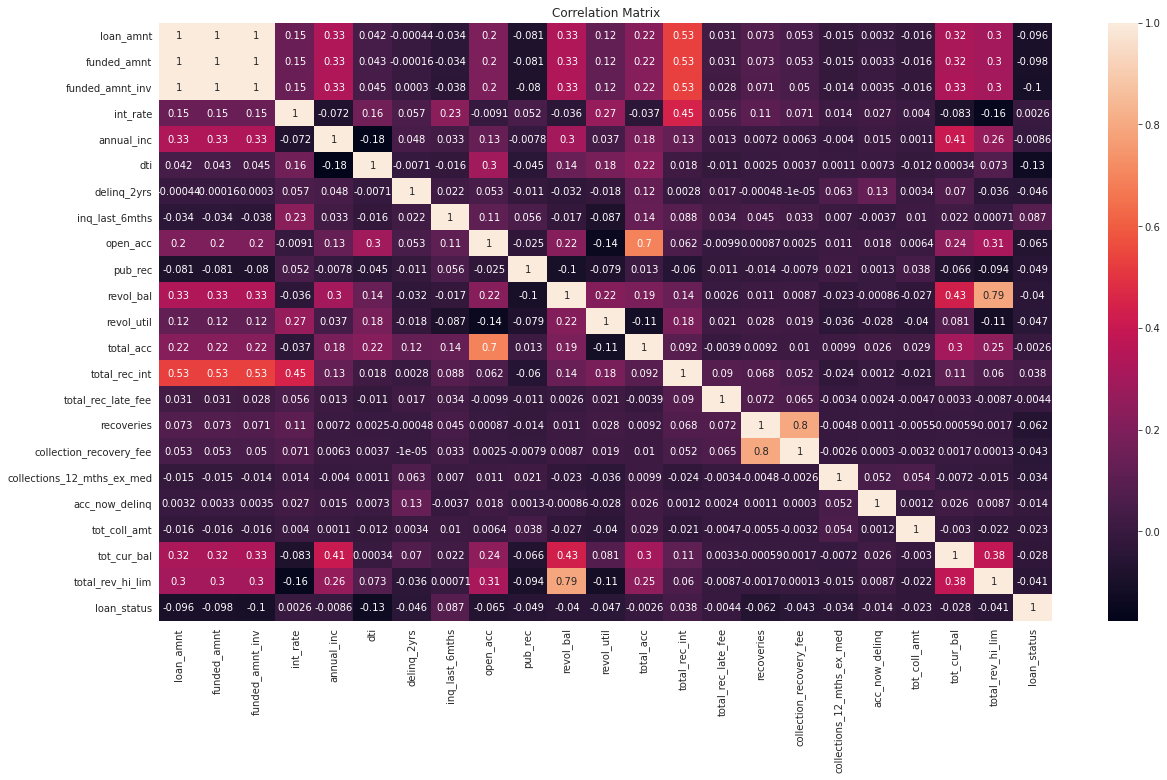

In [ ]:
plt.figure(figsize=(20,11))
sns.heatmap(train_data_preprocessed.corr(),annot=True)
plt.title("Correlation Matrix")
plt.show()



1.   loan amount , funded_amount and funded_amount_inv have correlation of 1 with each other that can will reduce model performence 
2.   we will drop funded_amount and funded_amount_inv



In [ ]:
train_data_preprocessed = train_data_preprocessed.drop(columns=['funded_amnt', 'funded_amnt_inv'])

# create new feature
- we dont have experties in bank domain , generally we can see if there is to much of loan with respect to monthly income then person will no able to complete loan 
- new feature = log(loan_amount + intrest_rate * term_of_loan)+0.00001/log(anual_income)+0.00001
- used log to reduce correlaiton and  0.00001 noice prevent us from devide by zero error
- if pdf of this feature will not show significant seperation then we will take this feature  

In [ ]:
import math
train_data_preprocessed['paybility'] = train_data_preprocessed.apply(lambda row: (math.log(row.loan_amnt + (float(row.term.split('_')[0]) * row.int_rate)) + 0.00001 )/math.log(row.annual_inc), axis=1)

In [ ]:
train_data_preprocessed['paybility']

0         0.937054
1         0.772015
2         0.862030
3         0.835694
4         0.893638
            ...   
532423    0.884233
532424    0.861602
532425    0.929137
532426    0.924028
532427    0.848782
Name: paybility, Length: 532428, dtype: float64

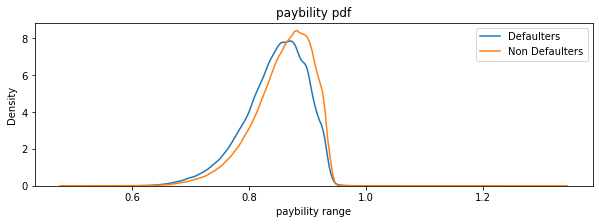

In [ ]:
plotPdf('paybility')

- its seperating regions cosiderable we will keep this feature 


# Modeling 
- train test split
- oversampling of train dataset
- normalize numerical features as we dont want to loose original distribution of dataser
- one hot encoading of categorical features
- after dataset is ready load into model we will apply (Logistic regression , GBDT , RandomForest)
  - cross validation using random serach
  - plot auc-roc value against epocs
  - draw roc cusrve on both train and test
  - draw confussion metrix in from best threshold
- we will also try small mlp nural network with dence layers
- compaire models and select model having heighest AUC-ROC score
- predict submission data

In [ ]:
#train_data_preprocessed.to_pickle("train_data_preprocessed.pkl")
train_data_preprocessed = pd.read_pickle("train_data_preprocessed.pkl")

In [ ]:
train_data_preprocessed.shape

(532428, 36)

In [ ]:
y = train_data_preprocessed['loan_status']
X_data = train_data_preprocessed.drop(columns=['loan_status'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train_old, X_test, y_train_old, y_test = train_test_split(X_data, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state=42)

In [ ]:
#!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:

print(Counter(y_train_old))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.5,random_state=42)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train_old, y_train_old)
# summarize class distribution
print(Counter(y_over))

Counter({0: 325280, 1: 100662})
Counter({0: 325280, 1: 162640})


In [ ]:
X_train , y_train = X_over, y_over

# normalizing numerical features

In [ ]:
from sklearn.preprocessing import Normalizer

numerical_features = ['loan_amnt', 'int_rate',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim','paybility']

In [ ]:
X_test.shape

(106486, 35)

In [ ]:
X_train.shape

(487920, 35)

In [ ]:
X_train_numerical_features = X_train[numerical_features].values
X_test_numerical_features = X_test[numerical_features].values

In [ ]:
X_train[numerical_features]

loan_amnt  int_rate  ...  total_rev_hi_lim  paybility
0            8950     15.99  ...           21100.0   0.904719
1           11900     18.54  ...           15900.0   0.919721
2            6000     12.49  ...           15700.0   0.810718
3            5200      6.54  ...           23700.0   0.766193
4           10675     20.99  ...            5000.0   0.911511
...           ...       ...  ...               ...        ...
487915      10000      5.99  ...           23700.0   0.861016
487916       8000     10.99  ...           50100.0   0.791277
487917      21550     15.61  ...           49700.0   0.867431
487918      15000     12.99  ...           21200.0   0.854447
487919      10000     11.49  ...           23700.0   0.865844

[487920 rows x 21 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def normalize_feature(nmumerical_fetures):
  X_train_numerical_features = X_train[nmumerical_fetures].values
  X_test_numerical_features = X_test[nmumerical_fetures].values
  data = X_train_numerical_features
  scaler = MinMaxScaler()
  scaler.fit(data)
  pickle.dump(scaler, open('normelizers_numeric.pkl', 'wb'))
  X_train_numerical = scaler.transform(X_train_numerical_features)
  X_test_numerical = scaler.transform(X_test_numerical_features)
  return X_train_numerical , X_test_numerical

In [ ]:
X_train_numerical , X_test_numerical = normalize_feature(numerical_features)

In [ ]:
X_train_numerical.shape

(487920, 21)

In [ ]:
X_train.loan_amnt.value_counts()

10000    34360
12000    27810
15000    25783
20000    25199
35000    19220
         ...  
34700        1
29075        1
925          1
32575        1
33725        1
Name: loan_amnt, Length: 1368, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def vectorize_feature(features):
  for i in features:
    vectorizer = OneHotEncoder(handle_unknown='ignore')
    vectorizer.fit(X_train[i].values.reshape(-1,1)) # fit has to happen only on train data
    globals()[f"vectorizer_{i}"] = vectorizer
    pickle.dump(globals()[f"vectorizer_{i}"], open(f'vectorizers/vectorizer_{i}.pkl', 'wb'))
    # we use the fitted OneHotEncoader to convert the text to vector
    X_train_vectors = vectorizer.transform(X_train[i].values.reshape(-1,1))
    X_test_vectors = vectorizer.transform(X_test[i].values.reshape(-1,1))

    globals()[f"X_train_{i}"] = X_train_vectors
    globals()[f"X_test_{i}"] = X_test_vectors
    print("After one hot encoading of "+i)
    print(X_train_vectors.shape, y_train.shape)
    print(X_test_vectors.shape, y_test.shape)
    print("="*100)


In [ ]:
categorical_features_preprocessed = ['term','batch_enrolled','grade','sub_grade','emp_title','emp_length'
,'home_ownership','verification_status','purpose','title'
,'zip_code','addr_state','initial_list_status'
,'last_week_pay']
len(categorical_features_preprocessed)

14

In [ ]:
vectorize_feature(categorical_features_preprocessed)

After one hot encoading of term
(487920, 2) (487920,)
(106486, 2) (106486,)
After one hot encoading of batch_enrolled
(487920, 105) (487920,)
(106486, 105) (106486,)
After one hot encoading of grade
(487920, 7) (487920,)
(106486, 7) (106486,)
After one hot encoading of sub_grade
(487920, 35) (487920,)
(106486, 35) (106486,)
After one hot encoading of emp_title
(487920, 138934) (487920,)
(106486, 138934) (106486,)
After one hot encoading of emp_length
(487920, 12) (487920,)
(106486, 12) (106486,)
After one hot encoading of home_ownership
(487920, 6) (487920,)
(106486, 6) (106486,)
After one hot encoading of verification_status
(487920, 3) (487920,)
(106486, 3) (106486,)
After one hot encoading of purpose
(487920, 14) (487920,)
(106486, 14) (106486,)
After one hot encoading of title
(487920, 27853) (487920,)
(106486, 27853) (106486,)
After one hot encoading of zip_code
(487920, 907) (487920,)
(106486, 907) (106486,)
After one hot encoading of addr_state
(487920, 51) (487920,)
(106486, 51

In [ ]:
from scipy.sparse import hstack
X_train_final = hstack((X_train_numerical , X_train_term ,X_train_batch_enrolled,X_train_grade,X_train_sub_grade,X_train_emp_title,X_train_emp_length
,X_train_home_ownership,X_train_verification_status,X_train_purpose,X_train_title
,X_train_zip_code,X_train_addr_state,X_train_initial_list_status
,X_train_last_week_pay ))


In [ ]:

pickle.dump(X_train_final, open('X_train_final.pkl', 'wb'))

In [ ]:
X_test_final = hstack((X_test_numerical , X_test_term ,X_test_batch_enrolled,X_test_grade,X_test_sub_grade,X_test_emp_title,X_test_emp_length
,X_test_home_ownership,X_test_verification_status,X_test_purpose,X_test_title
,X_test_zip_code,X_test_addr_state,X_test_initial_list_status
,X_test_last_week_pay ))
pickle.dump(X_test_final, open('X_test_final.pkl', 'wb'))

In [ ]:
pickle.dump(y_train, open('y_train.pkl', 'wb'))
pickle.dump(y_test, open('y_test.pkl', 'wb'))

In [ ]:
pickle.dump(X_train_numerical, open('X_train_numerical.pkl', 'wb'))
pickle.dump(X_test_numerical, open('X_test_numerical.pkl', 'wb'))

In [ ]:
X_train_final = pickle.load(open('X_train_final.pkl', 'rb'))
X_test_final = pickle.load(open('X_test_final.pkl', 'rb'))

In [ ]:
X_train_csr = X_train_final.tocsr()
X_test_csr = X_test_final.tocsr()

In [ ]:
y_train = pickle.load(open('y_train.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))

In [ ]:
X_test_final

<106486x168049 sparse matrix of type '<class 'numpy.float64'>'
	with 2836048 stored elements in COOrdinate format>

#Apply Model

- first we apply logistic regression becase Liniar model give good results when dimentions are heigh

In [ ]:
def batch_predict(clf, data):
    """ this function predicts batch wise propablity 
        for given data over given model
    """

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

##Logistic Regression

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


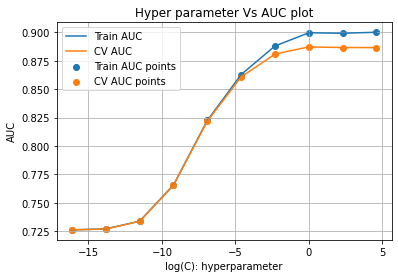

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       1.931660      0.041759  ...          0.726235         0.000389
1       1.559254      0.073042  ...          0.727051         0.000382
2       1.967143      0.039396  ...          0.733847         0.000328
3       3.106050      0.016808  ...          0.765705         0.000086
4       6.956268      0.078847  ...          0.822467         0.000044
5      15.453114      0.261965  ...          0.862777         0.000250
6      15.177733      0.358979  ...          0.887906         0.001693
7      15.282248      0.173678  ...          0.899523         0.001926
8      15.434415      0.144933  ...          0.899126         0.001063
9      15.478861      0.116143  ...          0.899997         0.002875

[10 rows x 17 columns]

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=15)
parameters = {'C':[1e-7,1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
clf = RandomizedSearchCV(clf, parameters, cv=3 ,scoring='roc_auc' ,return_train_score=True,random_state=15)

clf.fit(X_train_csr,y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
print(results.columns)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  list(map(lambda x: np.log(x) , results['param_C']))
#K = results['param_C']
plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results

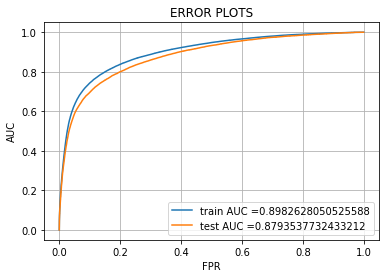

In [ ]:
#best  C is 1
from sklearn.metrics import roc_curve, auc

lr_model = LogisticRegression(C=1, random_state=15)
lr_model.fit(X_train_csr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(lr_model, X_train_csr)    
y_test_pred = batch_predict(lr_model, X_test_csr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
pickle.dump(lr_model, open('lr_model', 'wb'))

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.679641655354506 for threshold 0.335
Train confusion matrix
Test confusion matrix


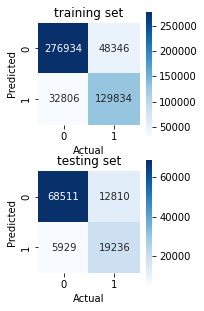

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt   
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
train_predict = predict_with_best_t(y_train_pred, best_t)
cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
#cm_train = confusion_matrix(y_train,train_predict)
#print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
test_predict = predict_with_best_t(y_test_pred, best_t)
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
#cm_test = confusion_matrix(y_test, test_predict)
#print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

fig = plt.figure(figsize = (5,5)) # width x height
ax1 = fig.add_subplot(2,2,1) # row, column, position
ax2 = fig.add_subplot(2,2,3)
  
ax1.set_title('training set')
cm_train = pd.DataFrame(cm_train)
cm_train['Predicted'] = [0,1]
cm_train.columns.name = 'Actual'
cm_train.set_index('Predicted',inplace=True)
sns.heatmap(cm_train,ax=ax1,square=True, annot=True,fmt="d",cmap='Blues')

ax2.set_title('testing set')
cm_test = pd.DataFrame(cm_test)
cm_test['Predicted'] = [0,1]
cm_test.columns.name = 'Actual'
cm_test.set_index('Predicted',inplace=True)
sns.heatmap(cm_test,ax=ax2,square=True, annot=True,fmt="d",cmap='Blues')

## GBDT

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [ ]:
parameters = {
 'learning_rate':[0.05,0.1,0.2,0.3],
 'n_estimators':[10,50,120,200]
}
xgb = XGBClassifier( 
 max_depth=3,
 subsample=0.8,
 colsample_bytree=0.8)

random_search = RandomizedSearchCV(xgb,parameters,cv=3,return_train_score=True,random_state=15,scoring='roc_auc')
random_search.fit(X_train_csr,y_train)

results = pd.DataFrame.from_dict(random_search.cv_results_)

results


mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       9.667801      0.496915  ...          0.764585         0.001853
1      31.940976      0.431594  ...          0.860757         0.004607
2     117.651682      1.100278  ...          0.858403         0.000115
3      71.379337      0.822498  ...          0.838266         0.000358
4      71.361843      0.580145  ...          0.907090         0.003358
5      32.100068      0.288634  ...          0.798859         0.001024
6     117.399010      1.028311  ...          0.938808         0.001881
7      71.746024      0.644654  ...          0.865048         0.000668
8      31.915615      0.393351  ...          0.879740         0.003140
9     116.421143      1.177270  ...          0.926831         0.002243

[10 rows x 18 columns]

In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np
import matplotlib.pyplot as plt

### plese ensure you have installed plotly to see below 3d graph

In [ ]:
x1,y1,z1 = results['param_n_estimators'],results['param_learning_rate'], results['mean_train_score']
x2,y2,z2 = results['param_n_estimators'],results['param_learning_rate'], results['mean_test_score']
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='param_n_estimators'),
        yaxis = dict(title='param_learning_rate'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
fig.show(renderer="colab")
plt.show()

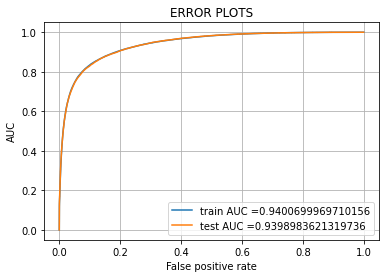

In [ ]:
# {'n_estimators': 200, 'learning_rate': 0.3} these are our best params
from sklearn.metrics import roc_curve, auc
xgbClf = XGBClassifier( 
 learning_rate = 0.3,
 n_estimators=200,
 max_depth=3,
 subsample=0.8,
 colsample_bytree=0.8)
xgbClf.fit(X_train_csr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(xgbClf, X_train_csr)    
y_test_pred = batch_predict(xgbClf, X_test_csr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
from sklearn.externals import joblib

joblib_file = "xgb_model.joblib"
joblib.dump(xgbClf, joblib_file)

['xgb_model.joblib']

In [ ]:
xgbClf = joblib.load('xgb_model.joblib') 

the maximum value of tpr*(1-fpr) 0.7521867978163548 for threshold 0.342
Train confusion matrix
Test confusion matrix


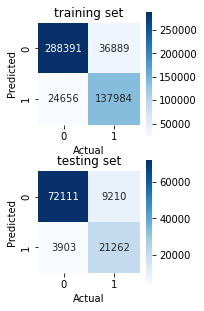

In [ ]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
train_predict = predict_with_best_t(y_train_pred, best_t)
cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
#cm_train = confusion_matrix(y_train,train_predict)
#print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
test_predict = predict_with_best_t(y_test_pred, best_t)
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
#cm_test = confusion_matrix(y_test, test_predict)
#print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

fig = plt.figure(figsize = (5,5)) # width x height
ax1 = fig.add_subplot(2,2,1) # row, column, position
ax2 = fig.add_subplot(2,2,3)
  
ax1.set_title('training set')
cm_train = pd.DataFrame(cm_train)
cm_train['Predicted'] = [0,1]
cm_train.columns.name = 'Actual'
cm_train.set_index('Predicted',inplace=True)
sns.heatmap(cm_train,ax=ax1,square=True, annot=True,fmt="d",cmap='Blues')

ax2.set_title('testing set')
cm_test = pd.DataFrame(cm_test)
cm_test['Predicted'] = [0,1]
cm_test.columns.name = 'Actual'
cm_test.set_index('Predicted',inplace=True)
sns.heatmap(cm_test,ax=ax2,square=True, annot=True,fmt="d",cmap='Blues',)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters={'n_estimators':[10,30,50,80,100],'max_depth': [1, 5, 10, 50]}
clf_tree=RandomForestClassifier()
random_search = RandomizedSearchCV(clf_tree,parameters,cv=3,return_train_score=True,random_state=15,n_iter=16,scoring='roc_auc')
random_search.fit(X_train_csr,y_train)

results = pd.DataFrame.from_dict(random_search.cv_results_)
print(results.columns)
results = results.sort_values(['param_max_depth'])

results

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_max_depth', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')


mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
2        8.053658      0.755660  ...          0.710498         0.009089
4        9.820057      0.928637  ...          0.691998         0.032478
5        5.109497      0.477210  ...          0.637429         0.010957
9        3.221154      0.271778  ...          0.618996         0.018599
3       35.680916      4.428566  ...          0.791857         0.008366
10      10.799898      1.211847  ...          0.721833         0.005188
13      17.858352      2.268550  ...          0.757287         0.008296
6        7.153913      0.885289  ...          0.724137         0.013648
8       54.829779      6.657790  ...          0.809414         0.006388
12      68.294789      8.097947  ...          0.808040         0.006578
14      21.078361      2.516116  ...          0.788913         0.005481
0      452.040343     38.835618  ...          0.900459         0.004362
1       44.561542      4.798198  ...          0.848499         0.010950
7      134.166251     14.245967  ...          0.883674         0.003985
11     224.039160     21.466611  ...          0.892269         0.004467
15     363.562780     37.001578  ...          0.897993         0.003660

[16 rows x 18 columns]

In [ ]:
x1,y1,z1 = results['param_n_estimators'],results['param_max_depth'], results['mean_train_score']
x2,y2,z2 = results['param_n_estimators'],results['param_max_depth'], results['mean_test_score']
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='param_n_estimators'),
        yaxis = dict(title='param_max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
fig.show(renderer="colab")
plt.show()

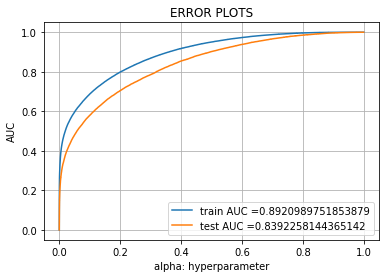

In [ ]:
#{'n_estimators': 100, 'max_depth': 50} are the best parameters
dtree = RandomForestClassifier(n_estimators=100,max_depth=50,random_state=15)
dtree.fit(X_train_csr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(dtree, X_train_csr)    
y_test_pred = batch_predict(dtree, X_test_csr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.6399008804688818 for threshold 0.341
Train confusion matrix w2v
Test confusion matrix w2v


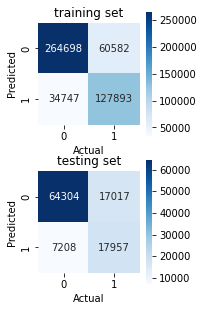

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix w2v")
train_predict = predict_with_best_t(y_train_pred, best_t)
cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
#cm_train = confusion_matrix(y_train,train_predict)
#print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix w2v")
test_predict = predict_with_best_t(y_test_pred, best_t)
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
#cm_test = confusion_matrix(y_test, test_predict)
#print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

fig = plt.figure(figsize = (5,5)) # width x height
ax1 = fig.add_subplot(2,2,1) # row, column, position
ax2 = fig.add_subplot(2,2,3)
  
ax1.set_title('training set')
cm_train = pd.DataFrame(cm_train)
cm_train['Predicted'] = [0,1]
cm_train.columns.name = 'Actual'
cm_train.set_index('Predicted',inplace=True)
sns.heatmap(cm_train,ax=ax1,square=True, annot=True,fmt="d",cmap='Blues')

ax2.set_title('testing set')
cm_test = pd.DataFrame(cm_test)
cm_test['Predicted'] = [0,1]
cm_test.columns.name = 'Actual'
cm_test.set_index('Predicted',inplace=True)
sns.heatmap(cm_test,ax=ax2,square=True, annot=True,fmt="d",cmap='Blues')

In [ ]:
joblib.dump(dtree, 'rdtree.joblib')

['rdtree.joblib']

In [ ]:
import tensorflow as tf
import random as rn
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.models import Model

In [ ]:
def aucroc(y_true, y_pred):
    m = tf.keras.metrics.AUC()
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [ ]:
def chage_sparce_to_dence(sparce_mat):
  reaturn_mat = []
  for i in tqdm(range(0,sparce_mat.shape[0])):
    if reaturn_mat == []:
      reaturn_mat = sparce_mat[i,:].toarray()
      continue
    reaturn_mat = np.concatenate((reaturn_mat, sparce_mat[i,:].toarray() ), axis=0)
  return reaturn_mat
  

In [ ]:
X_train_dence = pd.DataFrame.sparse.from_spmatrix(X_train_csr)
X_test_dence = pd.DataFrame.sparse.from_spmatrix(X_test_csr)

In [ ]:
X_train_dence

0         1         2         3       ...  168045  168046  168047  168048
0       0.244928  0.450782  0.002506  0.031404  ...     0.0     0.0     0.0     0.0
1       0.330435  0.558513  0.003006  0.022795  ...     0.0     0.0     0.0     0.0
2       0.159420  0.302915  0.005137  0.018988  ...     0.0     0.0     0.0     0.0
3       0.136232  0.051542  0.007769  0.018394  ...     0.0     0.0     0.0     0.0
4       0.294928  0.662019  0.002999  0.022111  ...     0.0     0.0     1.0     0.0
...          ...       ...       ...       ...  ...     ...     ...     ...     ...
487915  0.275362  0.028306  0.004646  0.007792  ...     0.0     0.0     0.0     0.0
487916  0.217391  0.239544  0.009456  0.035657  ...     0.0     0.0     0.0     0.0
487917  0.610145  0.434728  0.010822  0.010617  ...     0.0     0.0     0.0     0.0
487918  0.420290  0.324039  0.008296  0.004238  ...     0.0     0.0     0.0     0.0
487919  0.275362  0.260668  0.004611  0.015895  ...     0.0     0.0     0.0     0.0

[487920 rows x 168049 columns]

#- Note i wrote a logic tried multiple times to run below nural network but because i was working on colab and its provide only 12gb ram it was got creashed during training so did not perform full training but i kept logic as it is 

In [ ]:

X_input =  Input(shape=(X_train_dence.shape[1]), name= 'X_input', sparse=True)
Dence0 =  Dense(32,activation="relu",kernel_initializer='he_uniform')(X_input)

Dence1 =  Dense(32,activation="relu",kernel_initializer='he_uniform')(Dence0)
Dropout1 = Dropout(0.1)(Dence1)
Dence2 = Dense(64,activation="relu",kernel_initializer='he_uniform')(Dropout1)
BnLayer =  BatchNormalization()(Dence2)
Dropout2 = Dropout(0.1)(BnLayer)
Dence3 = Dense(64,activation="relu",kernel_initializer='he_uniform')(Dropout2)

output = Dense(1,activation="sigmoid",kernel_initializer='he_uniform')(Dence3)
model = Model(inputs=X_input, outputs=output)

earlystop = EarlyStopping(monitor='aucroc', min_delta=0.0000001, patience=4, verbose=2,mode='auto')

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',aucroc],run_eagerly=True)
save_model = model.fit( x=X_train_dence,y=y_train,batch_size=100,epochs=25,validation_data=(X_test_dence,y_test),callbacks=[earlystop])

#Load and Predict Funtions

In [ ]:
train_data_preprocessed = pd.read_pickle("train_data_preprocessed.pkl")
train_data_preprocessed.columns

Index(['loan_amnt', 'term', 'batch_enrolled', 'int_rate', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'collections_12_mths_ex_med',
       'last_week_pay', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'loan_status', 'paybility'],
      dtype='object')

# **Result summary in tabular form**

<table class="styled-table" >
    <thead>
        <tr>
            <th>Model</th>
            <th>Hyperparameter</th>
            <th>Validation Auc</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Logistic regression classifier</td>
            <td>C = 1</td>
            <td>0.879</td>
        </tr>
        <tr class="active-row">
            <td>GBDT classifier</td>
            <td>n_estimators = 200 , learning_rate = 0.3</td>
            <td>0.9398</td>
        </tr>
        <tr class="active-row">
            <td>Random Forest</td>
            <td>n_estimators = 100 , max_depth = 50</td>
            <td>0.839</td>
        </tr>
        <!-- and so on... -->
    </tbody>
</table>

### so gbdt shows best auc score of 0.9398  with least overfitting so we will choose gbdt model to predict our submissions

In [ ]:
def text_operations(features):
  for i in features:
    train_data_preprocessed[i] = train_data_preprocessed[i].map(lambda x: x.lower().replace(' ','_'))

In [ ]:
text_operations(['term','batch_enrolled','grade','sub_grade','emp_title','emp_length'
,'home_ownership','verification_status','purpose','title'
,'zip_code','addr_state','initial_list_status'
,'last_week_pay'])

In [ ]:
def predict_paybility(row):
  annual_inc = row.annual_inc 
  if row.annual_inc == 0:
    #small value to ignore log(0) error
    annual_inc = 0.0001
  return (math.log(row.loan_amnt + (float(row.term.split('_')[0]) * row.int_rate)) + 0.00001 )/math.log(annual_inc)

In [ ]:
import math
from scipy.sparse import hstack
from sklearn.externals import joblib
def load_predict():
  test_data = pd.read_csv('test_indessa.csv')
  member_id = test_data.member_id
  
  # select selected features which is in train_preprocessing
  test_data = test_data[['loan_amnt', 'term', 'batch_enrolled', 'int_rate', 'grade', 'sub_grade',
        'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
        'verification_status', 'purpose', 'title', 'zip_code', 'addr_state',
        'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
        'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
        'total_rec_int', 'total_rec_late_fee', 'recoveries',
        'collection_recovery_fee', 'collections_12_mths_ex_med',
        'last_week_pay', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
        'total_rev_hi_lim']]
  
  #replace nan and black spaces in batch enrolled
  test_data['batch_enrolled'] = test_data['batch_enrolled'].fillna('unknown')
  test_data['batch_enrolled'] = test_data['batch_enrolled'].map(lambda x: 'blank' if x == ' ' else x)
  
  # fill nan values
  median_value_features = pickle.load(open('save_feature_median_value.pickle', 'rb'))
  max_value_features = pickle.load(open('save_feature_max_value.pickle', 'rb'))
  for i in median_value_features.keys():
    test_data[i] = test_data[i].fillna(median_value_features[i])
  for j in max_value_features.keys():
    test_data[j] = test_data[j].fillna(max_value_features[j])

  #preprocess categorica data
  cat_features = ['term','batch_enrolled','grade','sub_grade','emp_title','emp_length'
  ,'home_ownership','verification_status','purpose','title'
  ,'zip_code','addr_state','initial_list_status'
  ,'last_week_pay']
  for i in cat_features:
      test_data[i] = test_data[i].map(lambda x: x.lower().replace(' ','_'))

  #create new feature
  test_data['paybility'] =  test_data.apply(lambda row: predict_paybility(row), axis=1)

  #normalize numerical features
  numerical_features = ['loan_amnt', 'int_rate',
        'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
        'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_int',
        'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
        'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
        'tot_cur_bal', 'total_rev_hi_lim','paybility']
  normelizer_scaler = pickle.load(open('normelizers_numeric.pkl', 'rb'))
  test_data_numerical_features = test_data[numerical_features].values  
  test_data_numerical = normelizer_scaler.transform(test_data_numerical_features)

  #one hot encode categorical features
  categorical_features = ['term','batch_enrolled','grade','sub_grade','emp_title','emp_length'
  ,'home_ownership','verification_status','purpose','title'
  ,'zip_code','addr_state','initial_list_status'
  ,'last_week_pay']
  for i in categorical_features:
    vector = pickle.load(open(f'vectorizers/vectorizer_{i}.pkl', 'rb'))
    test_feature = vector.transform(test_data[i].values.reshape(-1,1))
    globals()[f"test_feature_{i}"] = test_feature

  test_data_final = hstack((test_data_numerical , test_feature_term ,test_feature_batch_enrolled,test_feature_grade,test_feature_sub_grade,test_feature_emp_title,test_feature_emp_length
  ,test_feature_home_ownership,test_feature_verification_status,test_feature_purpose,test_feature_title
  ,test_feature_zip_code,test_feature_addr_state,test_feature_initial_list_status
  ,test_feature_last_week_pay )).tocsr()

  #predict probablities
  xgbClf = joblib.load('xgb_model.joblib') 
  y_probabilities = batch_predict(xgbClf , test_data_final )
  test_submission_df = pd.DataFrame({'member_id':member_id, 'loan_status':y_probabilities})
  test_submission_df.to_csv('test_submission.csv')
  test_submission_df.head()

load_predict()

member_id  loan_status
0   11937648     0.410839
1   38983318     0.291551
2   27999917     0.164921
3   61514932     0.206364
4   59622821     0.304588